# Figure 15: Spatial Correlation of Speckle Noise

<div style="text-align: justify">
This code is used to create **Figure 15** in the **Apples with Apples** paper [(Bonse et al. 2023)](../../05_citation.rst). The code computes the correlation of pixel values w.r.t its neighbours. This correlation seems to be different for different separations from the star. Moreover, it is dependent on the number of PCA components used. Since, we aim for independent noise observations (see [Figure 3](03_Independence.ipynb)) this effect should be investigated in more detail in future work.
</div>

## Imports

In [1]:
import os
import json
from pathlib import Path
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from applefy.gaussianity.residual_tests import extract_circular_annulus
from applefy.utils.positions import center_subpixel
from applefy.utils.file_handling import read_apples_with_apples_root, open_fits, load_adi_data

## Data Loading

For the plot we need the following data:
- The PSF template / unsaturated PSF of the star
- The residual stack after classical ADI. That is, the sequence of residual frames before temporal averaging.
- The residual stack after PCA with 30 components.

The residual stacks have been calculated with [PynPoint](https://pynpoint.readthedocs.io/en/latest/).

In order to run the code **make sure to download the data from Zenodo and [read the instructions](../02_paper_data.md) on how to setup the files**.

In [2]:
experiment_root = read_apples_with_apples_root()

Data in the APPLES_ROOT_DIR found. Location: /home/ipa/quanz/user_accounts/mbonse/2021_Metrics/70_results/apples_root_dir


Load the PSF template / unsaturated PSF.

In [3]:
dataset_file = experiment_root / Path("30_data/betapic_naco_lp_LR.hdf5")
science_data_key = "science_no_planet"
psf_template_key = "psf_template"
parang_key = "header_science_no_planet/PARANG"

dit_psf_template = 0.02019
dit_science = 0.2
fwhm = 4.2  # estimeated with Pynpoint in advance

In [4]:
# we need the psf template for contrast calculation
_, _, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag=science_data_key,
    psf_template_tag=psf_template_key,
    para_tag=parang_key)

psf_template_data = raw_psf_template_data[82:-82, 82:-82]

Load the processed and rotated PCA residual stacks. We computed them with PynPoint.

In [5]:
residual_stack_cADI = open_fits(
    os.path.join(experiment_root, 
                 "70_results/ADI_stacks/cADI_stack.fits"))
    
residual_stack_PCA = open_fits(
    os.path.join(experiment_root, 
                 "70_results/ADI_stacks/30_PCA_stack.fits"))

## Compute spatial correlations along time

We can calculate the spatial correlations along time by a simple matrix multiplication. For this we have to re-arange and reshape the dimensions of the *residual_stacks*.

In [6]:
residual_stack_cADI = residual_stack_cADI.swapaxes(0, 2)
residual_stack_PCA = residual_stack_PCA.swapaxes(0, 2)

In [7]:
residual_stack_cADI_reshape = residual_stack_cADI.reshape(
    residual_stack_cADI.shape[0]*residual_stack_cADI.shape[1], 
    residual_stack_cADI.shape[2])

residual_stack_PCA_reshape = residual_stack_PCA.reshape(
    residual_stack_PCA.shape[0]*residual_stack_PCA.shape[1], 
    residual_stack_PCA.shape[2])

Compute the spatial correlations.

In [8]:
correlation_map_cADI = np.matmul(residual_stack_cADI_reshape, 
                                 residual_stack_cADI_reshape.T)
correlation_map_PCA = np.matmul(residual_stack_PCA_reshape, 
                                residual_stack_PCA_reshape.T)

<div style="text-align: justify">
In total we obtain one *correlation_map* for each spatial pixel in the residual. Each *correlation_map* contains the correlation of the respective pixel w.r.t. all other pixels in the residual. We need to reshape the results of the previous step in order to obtain the *correlation_maps*.
</div>

In [9]:
correlation_map_PCA = correlation_map_PCA.reshape(
    residual_stack_PCA.shape[0], residual_stack_PCA.shape[1],
    residual_stack_PCA.shape[0], residual_stack_PCA.shape[1])

correlation_map_cADI = correlation_map_cADI.reshape(
    residual_stack_cADI.shape[0], residual_stack_cADI.shape[1],
    residual_stack_cADI.shape[0], residual_stack_cADI.shape[1])

## Correlation maps as a function of separation

<div style="text-align: justify">
As a next step we calculate the *typical* correlations of the pixel depending on their separation from the star. This is important for the hypothesis tests as they require neighbouring noise observations to be independent.
    
We start by selecting pixel positions at two different separations: $2 \lambda /D$ and $5 \lambda /D$.
</div>

In [10]:
# Create two masks for the inner and outer region
# 4.2 is the PSF-FWHM
_, positions_inner, mask = extract_circular_annulus(
    input_residual_frame=residual_stack_cADI[:, :, 0],
    separation=2,
    size_resolution_elements=4.2,
    annulus_width=1.)

_, positions_outer, mask = extract_circular_annulus(
    input_residual_frame=residual_stack_cADI[:, :, 0],
    separation=5,
    size_resolution_elements=4.2,
    annulus_width=1.)

Create a function which extracts and sums the local correlations.

In [11]:
def compute_spatial_correlation(correlation_map_in,
                                positions_in):

    area_size = 11
    
    # An empty image to accumulate the local correlations
    area_sum = np.zeros((2*area_size-1, 2*area_size-1))
    
    # For each position in the annulus
    for tmp_position in positions_in:
        
        area_sum += correlation_map_in[
            # Select the current position from all correlation_maps
            tmp_position[0], tmp_position[1],
            # Extract a small local window from the map
            tmp_position[0]-area_size+1:tmp_position[0]+area_size,
            tmp_position[1]-area_size+1:tmp_position[1]+area_size]
        
    return area_sum

Compute the local correlation_maps for PCA and cADI.

In [12]:
pca_inner_map = compute_spatial_correlation(correlation_map_PCA, positions_inner)
pca_outer_map = compute_spatial_correlation(correlation_map_PCA, positions_outer)
cadi_inner_map = compute_spatial_correlation(correlation_map_cADI, positions_inner)
cadi_outer_map = compute_spatial_correlation(correlation_map_cADI, positions_outer)

## Create the Plot

A small function to plot one of the four local correlation maps.

In [13]:
def plot_correlation(axis_in,
                     map_in):
    
    # Show the PSF
    axis_in.imshow(map_in, 
                   vmin=np.min(map_in), 
                   vmax=np.max(map_in)*0.9)

    # Remove the axis 
    axis_in.axes.get_xaxis().set_ticks([])
    axis_in.axes.get_yaxis().set_ticks([])

A small function to plot one of the 1d profiles.

In [14]:
def plot_1d_line(axis_in,
                 map_in,
                 color_in,
                 label_in):
    
    # Extract a 1d line from the correlation map
    tmp_line = deepcopy(map_in[:,10])
    tmp_line /= np.max(tmp_line)
    
    x_space = (np.linspace(0, 20, 21) - 10) / 3.8
    
    # Plot it
    axis_in.plot(x_space, tmp_line,
                 lw=3,label=label_in,
                 color = color_in)
    
    # Limit and ticks
    axis_in.set_ylim(-0.4, 1.3)
    axis_in.set_xlim(np.min(x_space),
                     np.max(x_space))
    axis_in.set_xticks(np.arange(-2.5, 2.5, 0.5))
    axis_in.grid()

A small function to draw and shade the annulus regions.

In [15]:
frame_center = center_subpixel(correlation_map_PCA[0, 0])

# draws a dashed cicle to mark the regions used
def draw_circle(axis_in,
                r_in, r_out):
    
    n, radii = 100, [r_in, r_out]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))

    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]

    axis_in.fill(np.ravel(xs)+frame_center[0],
                 np.ravel(ys)+frame_center[1], 
                 fc='white', ec = "none",alpha=0.1)
    
    axis_in.set_xlim(0, correlation_map_PCA[0, 0].shape[0]-1)
    axis_in.set_ylim(0, correlation_map_PCA[0, 0].shape[0]-1)
    
    circle = plt.Circle(frame_center, r_in, ls="--", ec='white', fc="none", alpha=0.5)
    axis_in.add_patch(circle)
    
    circle = plt.Circle(frame_center, r_out, ls="--", ec='white', fc="none", alpha=0.5)
    axis_in.add_patch(circle)
    
    axis_in.invert_yaxis()

Create the actual Plot.

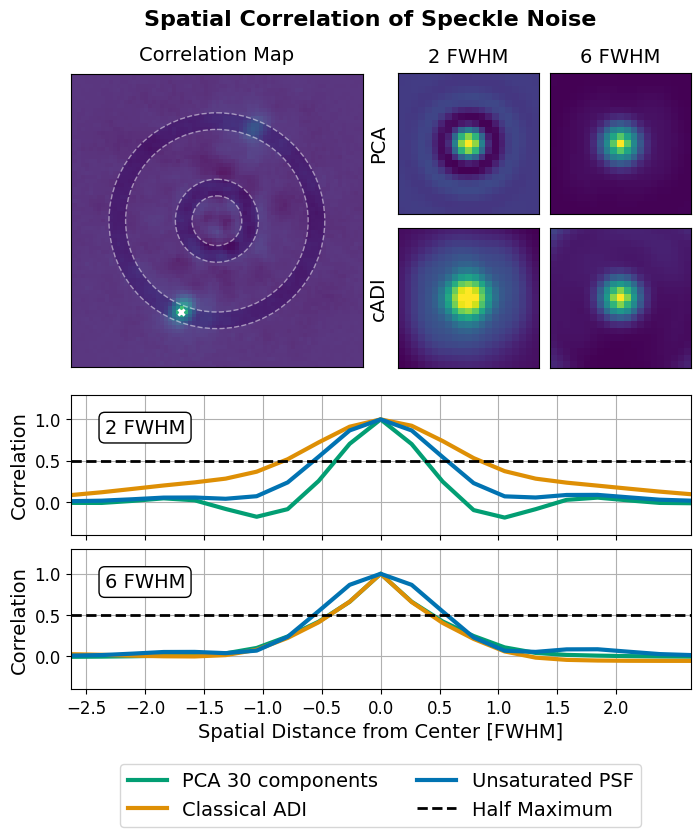

In [16]:
# 1.) Create the plot Layout --------------------------
fig = plt.figure(constrained_layout=False, 
                 figsize=(8, 8))

gs0 = fig.add_gridspec(2, 2, height_ratios=[1, 1])
gs0.update(hspace=0.09, wspace=0.12)

# Used for the four local correlation maps
gs1 = gridspec.GridSpecFromSubplotSpec(
    2, 2, 
    subplot_spec=gs0[0, 1],
    hspace=0.1, wspace=0.08,
    width_ratios=[1, 1])

# Used for the 1d profiles
gs2 = gridspec.GridSpecFromSubplotSpec(
    2, 1, 
    subplot_spec=gs0[1, :],
    hspace=0.1, wspace=0.1)

ax_correlation_example = fig.add_subplot(gs0[0, 0])
ax_pca_inner = fig.add_subplot(gs1[0, 0])
ax_pca_outer = fig.add_subplot(gs1[0, 1])
ax_cadi_inner = fig.add_subplot(gs1[1, 0])
ax_cadi_outer = fig.add_subplot(gs1[1, 1])

ax_illustration_inner = fig.add_subplot(gs2[0])
ax_illustration_outer = fig.add_subplot(gs2[1])

# 2.) Plot one correlation map as an example ----------
plot_correlation(
    ax_correlation_example, 
    correlation_map_PCA[positions_outer[-42][0], 
                        positions_outer[-42][1]])

ax_correlation_example.scatter(
    positions_outer[-42][1],
    positions_outer[-42][0],
    marker="x", s=20,
    color="white", lw=2)

draw_circle(ax_correlation_example, 0, 4.2*1.5)
draw_circle(ax_correlation_example, 4.2*2.5, 4.2*5.5)
draw_circle(ax_correlation_example, 4.2*6.5, 4.2*20)

# 3.) Plot the averaged correlation maps --------------
plot_correlation(ax_pca_inner, pca_inner_map)
plot_correlation(ax_pca_outer, pca_outer_map)
plot_correlation(ax_cadi_inner, cadi_inner_map)
plot_correlation(ax_cadi_outer, cadi_outer_map)

# 4.) Plot the 1D profiles ----------------------------
plot_1d_line(ax_illustration_inner,
             pca_inner_map, 
             sns.color_palette("colorblind")[2],
             "PCA 30 components")

plot_1d_line(ax_illustration_inner, 
             cadi_inner_map - np.median(cadi_outer_map), 
             sns.color_palette("colorblind")[1],
             "Classical ADI")

plot_1d_line(ax_illustration_inner,
             psf_template_data, 
             sns.color_palette("colorblind")[0],
             "Unsaturated PSF")

plot_1d_line(ax_illustration_outer,
             pca_outer_map, 
             sns.color_palette("colorblind")[2],
             "PCA 30 components")

plot_1d_line(ax_illustration_outer,
             cadi_outer_map - np.median(cadi_outer_map), 
             sns.color_palette("colorblind")[1],
             "Classical ADI")

plot_1d_line(ax_illustration_outer, psf_template_data, 
             sns.color_palette("colorblind")[0],
             "Unsaturated PSF")

ax_illustration_inner.axhline(
    0.5, color="black", lw=2, 
    ls="--", label="Half Maximum")
ax_illustration_outer.axhline(
    0.5, color="black", lw=2, 
    ls="--", label="Half Maximum")

plt.setp(ax_illustration_inner.get_xticklabels(), 
         visible=False)

# 5.) Labels and Text ---------------------------------
ax_pca_inner.set_title(
    r"2 FWHM",fontsize=14,  y=1.02)

ax_pca_outer.set_title(
    r"6 FWHM", fontsize=14,  y=1.02)

ax_pca_inner.set_ylabel(r"PCA", fontsize=14)
ax_cadi_inner.set_ylabel(r"cADI", fontsize=14)

ax_correlation_example.set_title(
    r"Correlation Map",
    fontsize=14,  y=1.02)

ax_illustration_outer.set_xlabel(
    r"Spatial Distance from Center [FWHM]",
    fontsize=14)

ax_illustration_inner.set_ylabel(
    "Correlation", fontsize=14)

ax_illustration_outer.set_ylabel(
    "Correlation", fontsize=14)

ax_illustration_inner.text(
    -2., 0.9, r"2 FWHM", 
    va="center", ha="center", fontsize=14,
    bbox=dict(facecolor='white',
              boxstyle="round",
              edgecolor="black"))

ax_illustration_outer.text(
    -2., 0.9, r"6 FWHM", 
    va="center", ha="center", fontsize=14,
    bbox=dict(facecolor='white',
              boxstyle="round",
              edgecolor="black"))

ax_illustration_inner.tick_params(
    axis='both', which='major', labelsize=12)
ax_illustration_outer.tick_params(
    axis='both', which='major', labelsize=12)

# 6.) Create the Legend -------------------------------
lgd = ax_illustration_outer.legend(
    ncol=2, fontsize=14, 
    loc='lower center',
    bbox_to_anchor=(0.5, -1.05))


st = fig.suptitle(
    "Spatial Correlation of Speckle Noise", 
    fontsize=16, fontweight="bold", y=0.96)

# 7.) Save the figure ---------------------------------
fig.patch.set_facecolor('white')
plt.savefig("./15_Spatial_Correlation_of_Speckles.pdf", 
            bbox_extra_artists=(lgd, st), 
            bbox_inches='tight')